In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
# %matplotlib notebook
%matplotlib notebook
mpl.style.use('ggplot') # optional: for ggplot-like style

mpl.rcParams['font.sans-serif'] = ['FangSong'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

In [26]:
housedata =  pd.read_csv('data/lianjia100_clean.csv')

<IPython.core.display.Javascript object>


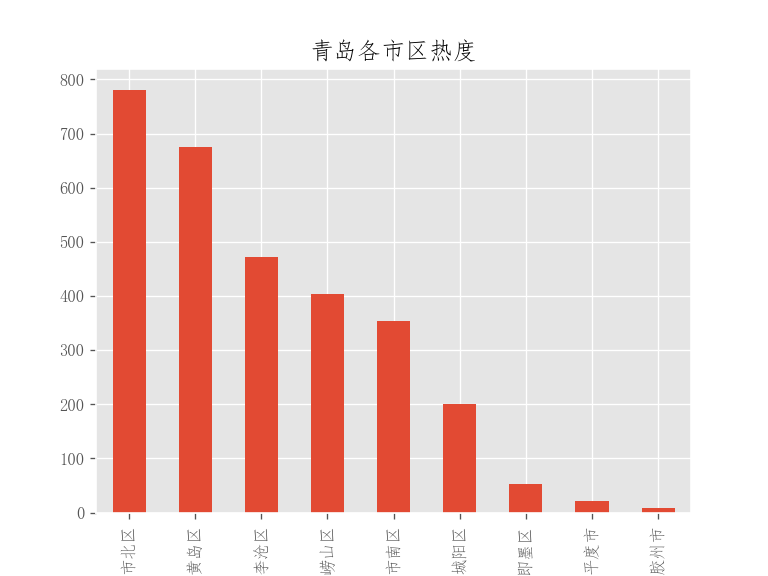

In [11]:
housedata['市区'].value_counts().plot(kind='bar')
plt.title('青岛各市区热度')

plt.savefig('fig/districts-trend.png')
plt.show()

<IPython.core.display.Javascript object>


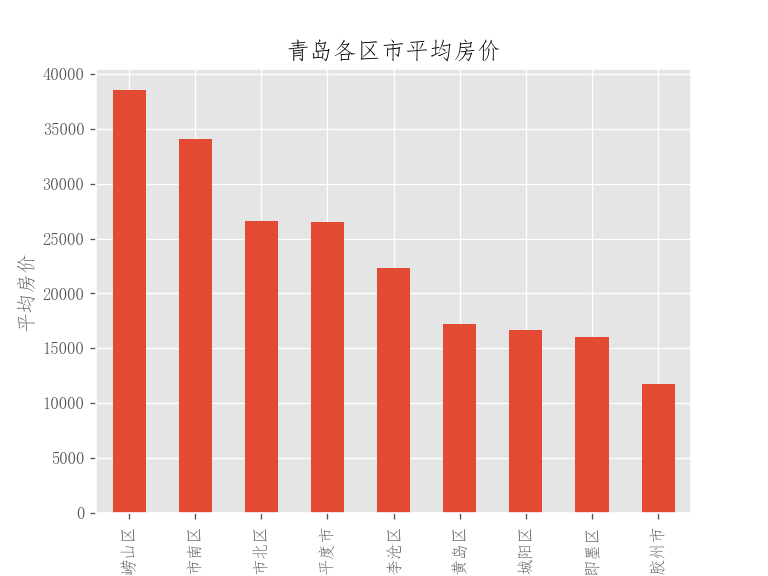

In [12]:
dist_price = pd.DataFrame([housedata['市区'],housedata['元/平米']]).T
dist_price['元/平米'] = pd.to_numeric(dist_price['元/平米'])
mean_price_dist = dist_price.groupby('市区')['元/平米'].mean().sort_values(ascending=False)
mean_price_dist.plot(kind='bar')
#plt.bar(dist_price['市区'],dist_price['元/平米'])
plt.title('青岛各区市平均房价')
plt.ylabel('平均房价')

plt.savefig('fig/districts-price.png')
plt.show()

In [41]:
print(housedata['元/平米'].mean())
print(housedata.loc[housedata['元/平米'].idxmax()])
print(housedata.loc[housedata['元/平米'].idxmin()])

25384.791245791246
标题        一楼复式带200平院子，开发商3000一平精装交付
挂牌价格/万                         1000
元/平米                          90131
tags                          房本满两年
小区名                         山水名园三期 
几室几厅                           4室2厅
总面积                             110
装修情况                             精装
有无电梯                            有电梯
别墅                              NaN
朝向                              南,北
区域                              石老人
楼层高低                            低楼层
楼共有几层                            15
建造年份                           2010
建筑形式                             板楼
几人关注                              1
带看次数                              0
多久以前发布                          3个月
几月以前发布                            3
几年以前发布                            0
几天以前发布                            0
市区                              崂山区
Name: 1527, dtype: object
标题        隆和水岸  交通便利配套齐全，小区环境好
挂牌价格/万                      40
元/平米                      7098
tags                 近地铁,房本满五年
小区名

In [24]:
dist_hot= pd.DataFrame([housedata['市区'],housedata['几人关注'],housedata['带看次数']]).T
dist_hot.head()

,市区,几人关注,带看次数
0,即墨区,18,6
1,黄岛区,21,23
2,黄岛区,16,11
3,李沧区,26,14
4,黄岛区,26,11


In [36]:
dist_hot_new = pd.DataFrame(dist_hot.groupby(['市区']).sum())
dist_hot_new.rename(columns ={0:'count'})
dist_hot_new.sort_values(['几人关注'], ascending = False,axis = 0,inplace = True )

<IPython.core.display.Javascript object>


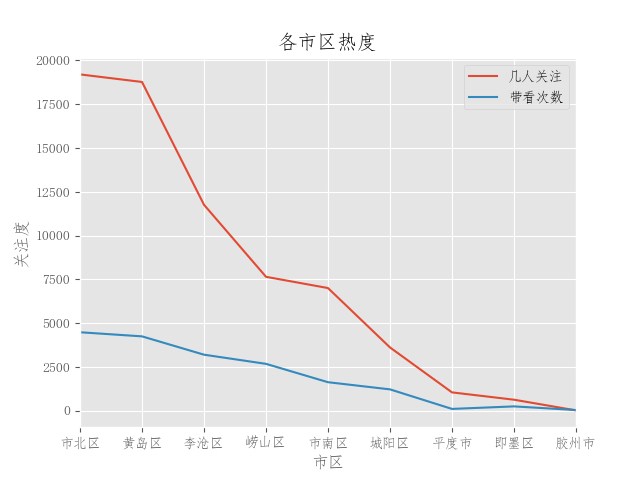

In [39]:
dist_hot_new.plot(kind='line')
plt.title('各市区热度')
plt.ylabel('关注度')
plt.xlabel('市区')
plt.savefig('fig/hotness-over-districts.png')
plt.show()

In [6]:
import folium
from folium.plugins import HeatMap
import numpy as np

In [25]:
newhouse = housedata.copy()
newhouse.sort_values(['元/平米'], ascending = False,axis = 0,inplace = True )

lat = np.array(newhouse["lat"][0:250])                        # 获取维度之维度值
lon = np.array(newhouse["lng"][0:250])                        # 获取经度值
price = np.array(newhouse["元/平米"][0:250],dtype=float)    # 获取人口数，转化为numpy float
data1 = [[lat[i],lon[i],price[i]] for i in range(0,250)]    #将数据制作成[lats,lons,weights]的形式
map_osm = folium.Map(location=[36.06605, 120.36939], zoom_start=12)    #绘制Map，开始缩放程度是10倍
HeatMap(data1).add_to(map_osm) # 将热力图添加到前面建立的map里
file_path = r'fig/price-heatmap.html'
map_osm.save(file_path)     # 保存为html文件

In [ ]:
# take some useful cols to do feature engineering, and see what are the most correlated variables.
# multivariables


housedata.drop(['标题','小区名','lat','lng'])

https://medium.com/@sebastiannorena/finding-correlation-between-many-variables-multidimensional-dataset-with-python-5deb3f39ffb3

In [32]:
housedata.columns

Index(['标题', '挂牌价格/万', '元/平米', 'tags', '小区名', '几室几厅', '总面积', '装修情况', '有无电梯',
       '别墅', '朝向', '区域', '楼层高低', '楼共有几层', '建造年份', '建筑形式', '几人关注', '带看次数',
       '多久以前发布', '几月以前发布', '几年以前发布', '几天以前发布', '市区', 'lat', 'lng'],
      dtype='object')

In [28]:
housedata.head()

,标题,挂牌价格/万,元/平米,tags,小区名,几室几厅,总面积,装修情况,有无电梯,别墅,...,建筑形式,几人关注,带看次数,多久以前发布,几月以前发布,几年以前发布,几天以前发布,市区,lat,lng
0,精装套一，干湿分离，12年新小区，位置好,92.0,12264,房本满两年,万科东郡,1室1厅,75,精装,有电梯,NaN,...,板楼,18,6,3个月,3,0,0,即墨区,36.394749,120.453536
1,经典套二 南北通透格局 采光好,127.0,14672,房本满两年,一中小区,2室1厅,86,精装,无电梯,NaN,...,板楼,21,23,1个月,1,0,0,黄岛区,35.978126,120.177032
2,怡和嘉园北区 精装修 交通便利 新小区,130.0,15145,房本满五年,怡和嘉园北区,2室1厅,85,精装,NaN,NaN,...,板楼,16,11,1个月,1,0,0,黄岛区,35.968361,120.228023
3,万达广场 经典正规套二 楼层好 随时看房,190.0,22801,"近地铁,房本满两年",万达中央公馆,2室1厅,83,简装,有电梯,NaN,...,板楼,26,14,5天,0,0,5,李沧区,36.172483,120.439694
4,怡和嘉园，70年产权 南北卧，西厅，采光好,130.0,14445,房本满五年,怡和嘉园北区,2室1厅,90,精装,有电梯,NaN,...,板楼,26,11,8天,0,0,8,黄岛区,35.968361,120.228023
